# **FAKE NEWS DETECTION**

“Fake news,” or fabricated information that is patently false, has become a major phenomenon in the context of Internet-based media. It has received serious attention in a variety of fields, with scholars investigating the antecedents, characteristics, and consequences of its creation and dissemination. As the scourge of “fake news” continues to plague our information environment, attention has turned toward devising automated solutions for detecting problematic online content.

This notebook aims to classify fake news from the real news using recurrent neural networks (to be specific, LSTMs).

The results are:

Accuracy on testing set: 0.9941202672605791

Precision on testing set: 0.9932665745856354

Recall on testing set: 0.9953287197231834

I shall explain the steps involved as we parse through this notebook.

# IMPORTING LIBRARIES

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [2]:
#For Visualization
from matplotlib import pyplot as plt
import seaborn as sns

#Libraries for text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#Importing Tensorflow for model creation
import tensorflow as tf

#Libraries that check the accuracy of the model over test set
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# IMPORTING DATASET

In [3]:
fake = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")
true = pd.read_csv("../input/fake-and-real-news-dataset/True.csv")

In [4]:
# Labelling data by adding the category column

fake["category"] = 1
true["category"] = 0

In [5]:
#Combining the two datasets

dataset = pd.concat([fake, true])

AxesSubplot(0.125,0.125;0.775x0.755)


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


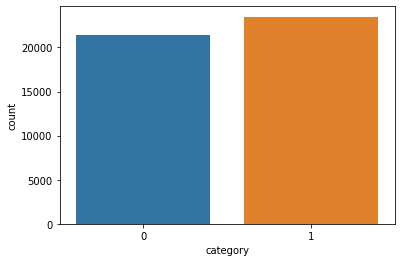

In [6]:
# Count of news in each category

print(sns.countplot(dataset.category))

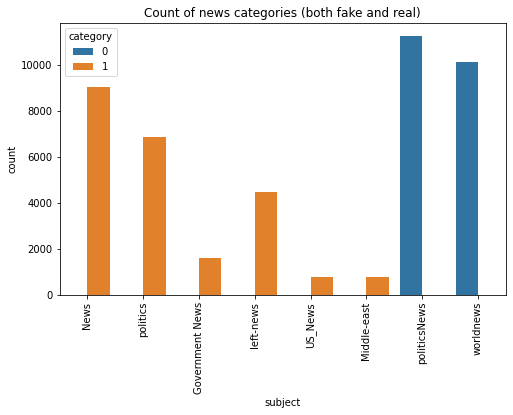

In [7]:
# Visualizing the count of each type of news based on the subject

f = plt.figure()
plt.title("Count of news categories (both fake and real)")
f.set_figwidth(8)
f.set_figheight(5)
plt.xticks(rotation = 90)
sns.countplot(x = "subject", hue = "category", data =  dataset)
plt.show()

# TEXT PREPROCESSING

In [8]:
# Combining the title of the news with it's text

dataset["text"] = dataset["text"]+" "+dataset["title"]

In [9]:
# Drop the unnecessary columns, title(already added to the text column), subject and date

dataset.drop(["title", "subject", "date"], axis = 1, inplace = True)

In [10]:
#Defining functions to clean text data

def remove_punctuation(text):  #Removing any kind of punctuation present in the data
    return re.sub(r'[^\w\s]','', str(text))
                  
def remove_urls(text):  #Removing urls from the data
    return re.sub(r"http\S+", " ", str(text))
                  
def remove_stopwords(text):  #Removing stopwords(eg. this, that, am, be etc)
    stop = stopwords.words("english")
    final_text = []
    for i in str(text).split():
        if i.strip() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
                  
def tokenize(text):  
    tokens = re.split('\W+',text) #W+ means that either a word character (A-Z) or a dash(-) can go there.
    return tokens

def tokenize_words(text):  #Converting all the text to lower case
    return word_tokenize(text.lower())

                                  
def stemming(text):  #Converting the words into their stem form
    porter_stemmer = PorterStemmer()
    return porter_stemmer.stem(str(text))
                  
def lemmatization(text):  #Applying Lemaatization i.e., converting words into their lemma
    wordnet_lemmatizer = WordNetLemmatizer()
    return wordnet_lemmatizer.lemmatize(str(text))

In [11]:
def clean_text(text):
    text = remove_punctuation(text)
    text = remove_urls(text)
    text = remove_stopwords(text)
    text = tokenize_words(text)
    text = stemming(text)
    return lemmatization(text)

dataset['text'] = dataset['text'].apply(lambda x: clean_text(x))

In [12]:
# Splitting the dataset into train and test set

x_train, x_test, y_train, y_test = train_test_split(dataset["text"], dataset["category"], test_size = 0.25, random_state = 12)

In [13]:
#Tokenize the words into vectors because we can only give numerical data as input to the model

max_vocab = 25000
tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [14]:
#Padding is applied so that we get the same length of input for each article

x_train = pad_sequences(x_train, padding = "post", maxlen = 256)
x_test = pad_sequences(x_test, padding = "post", maxlen = 256)

# BUILDING THE RNN

In [15]:
# Creating the model

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1)
])

model.summary()

2022-07-01 02:18:42.203741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 02:18:42.318781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 02:18:42.319557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 02:18:42.320758: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         3200000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,319,553
Trainable params: 3,319,553
Non-trainable params: 0
______________________________________________

In [16]:
# Training the model

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
             optimizer = tf.keras.optimizers.Adam(1e-4),
             metrics = ["accuracy"])

model.fit(x_train, y_train, epochs = 4, validation_split = 0.2, batch_size = 32, shuffle = True)

Epoch 1/4


2022-07-01 02:18:45.805033: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-01 02:18:51.425164: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


842/842 [==============================] - 45s 46ms/step - loss: 0.2294 - accuracy: 0.8766 - val_loss: 0.0551 - val_accuracy: 0.9832
Epoch 2/4
842/842 [==============================] - 37s 44ms/step - loss: 0.0215 - accuracy: 0.9951 - val_loss: 0.0219 - val_accuracy: 0.9952
Epoch 3/4
842/842 [==============================] - 37s 44ms/step - loss: 0.0115 - accuracy: 0.9979 - val_loss: 0.0185 - val_accuracy: 0.9955
Epoch 4/4
842/842 [==============================] - 37s 44ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.0242 - val_accuracy: 0.9952


In [17]:
# Evaluating the test set

model.evaluate(x_test, y_test)

351/351 [==============================] - 6s 18ms/step - loss: 0.0186 - accuracy: 0.9964


[0.018602222204208374, 0.9964365363121033]

In [18]:
y_pred = model.predict(x_test)

binary_prediction = []

for i in y_pred:
    if i>=0.5:
        binary_prediction.append(1)
    else:
        binary_prediction.append(0)

# LOOKING AT MODEL ACCURACY

In [19]:
print('Accuracy on testing set:', accuracy_score(binary_prediction, y_test))
print('Precision on testing set:', precision_score(binary_prediction, y_test))
print('Recall on testing set:', recall_score(binary_prediction, y_test))

Accuracy on testing set: 0.9964365256124722
Precision on testing set: 0.9975828729281768
Recall on testing set: 0.9955203308063405


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

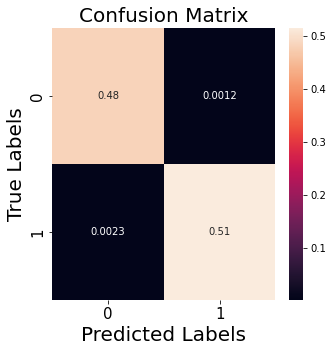

In [20]:
# Creating a heatmap to visualize the confusion matrix

matrix = confusion_matrix(binary_prediction, y_test, normalize='all')
plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)
